In [1]:
import geopandas_osm.osm
import numpy as np
import geopandas as gp
import pandas as pd
import fiona
import os
from shapely.geometry import Polygon
from shapely.geometry import shape
import shapely
from matplotlib import pyplot
import matplotlib.pyplot as plt
from ipyleaflet import Map, GeoData, basemaps, LayersControl
import geopandas
import json
import pyproj
import rioxarray
import xarray
from ipypb import track
import pickle
import glob
from pyrosm import OSM
from pyrosm import get_path

C:\Users\User\Anaconda3\envs\geo\lib\site-packages\pyrosm\utils\_compat.py:8: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). The tool will work but it runs a bit slower.
  warnings.warn(


In [2]:
c1_path = './Landsat/Cropped/Level 1/'
s_path = './Landsat/Scenes/'
m_path = './Landsat/Metadata/'
site_path = './In situ data/'
home = "E:/University College London/O'Sullivan, Aidan - SDG6/"

os.chdir(home)

### Check memory

In [3]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('GeoData', 1064),
 ('LayersControl', 1064),
 ('Map', 1064),
 ('OSM', 1064),
 ('Polygon', 1064),
 ('track', 1064),
 ('basemaps', 376),
 ('home', 213),
 ('get_path', 136),
 ('shape', 136),
 ('c1_path', 75),
 ('gp', 72),
 ('np', 72),
 ('pd', 72),
 ('plt', 72),
 ('pyplot', 72),
 ('m_path', 68),
 ('s_path', 66),
 ('site_path', 64)]

### Matching polygons to site id on codes

In [3]:
sites2 = pd.read_pickle(home+"sites2.p")

In [68]:
wb = gp.read_file('SurfaceWaterBody.shp')

In [5]:
## Add water body ID to sites list

wqdb = pd.read_csv(home+'In situ data/EEA_water_base/Waterbase_v2018_1_WISE4_MonitoringSite_DerivedData.csv',parse_dates=True)

sites = (sites
         .reset_index()
         .merge(wqdb[['monitoringSiteIdentifier','waterBodyIdentifier']],how='left',left_on='sid',right_on='monitoringSiteIdentifier')
         .rename(columns={'waterBodyIdentifier':'wbid'})
         .set_index(['sid','dt']))

In [6]:
### Checking membership of site ids

wbl = list(wb.localId)
wbl2 = list(wb.thematicId)
sl = list(sites.reset_index().wbid)

ml = [ i for i in sl if i in wbl ]
ml2 = [ i for i in sl if i in wbl2 ]
ml3 = [ i for i in wbl if i in wbl2 ]

len(ml),len(ml2),len(ml3)

(5768, 17318, 23704)

In [7]:
wb.loc[:,wb.columns.str.contains('Id')].head(2)

,localId,versionId,thematicId,themaIdSch,predecesId,predeIdSch,successoId,succeIdSch,rZoneId,rZoneIdSch,rTrnsId,rTrnsIdSch
0,OK10500000,wfd2016,ATOK10500000,euSurfaceWaterBodyCode,None,None,None,None,AT1001,euSubUnitCode,None,None
1,OK10500100,wfd2016,ATOK10500100,euSurfaceWaterBodyCode,None,None,None,None,AT1001,euSubUnitCode,None,None


In [8]:
wb = wb.to_crs(sites.crs)

In [9]:
sites2 = (sites
            .reset_index()
            .merge(wb[['thematicId','geometry']],how='left',left_on='wbid',right_on='thematicId')
            .rename(columns = {'geometry_x':'geometry_ll','geometry_y':'geometry_poly'})
            .set_index(['sid','dt'])
            .set_geometry('geometry_poly'))

sites2.crs = sites.crs

In [4]:
## Countries without matches
notmatch = [ i[0:2] for i in list(sites2[sites2.geometry_poly.isna()].reset_index().sid) ]

list(set(notmatch))

['SE', 'UK', 'LT', 'FR']

In [73]:
del(wb)

#### Adding in new data

In [156]:
sites_poly = gp.read_file(site_path+'eea_site_wpoly.shp')
sites = pd.read_pickle("E:/OneDrive - University College London/O'Sullivan, Aidan - SDG6/sites.p")
sites_poly.head(2)

,sid,geometry
0,ATSE20101000,"POLYGON ((14.13527 46.63643, 14.13592 46.63628..."
1,ATSE20201000,"POLYGON ((13.53752 46.81525, 13.53851 46.81497..."


In [158]:
sites3 = (sites
          .reset_index()
          .merge(sites_poly,how='left',on='sid')
          .rename(columns = {'geometry_x':'geometry_ll','geometry_y':'geometry_poly'})
          .set_index(['sid','dt']))


sites3 = gp.GeoDataFrame(sites3,geometry='geometry_ll', crs = sites_poly.crs)

print(type(sites3))

sites3.head()

<class 'geopandas.geodataframe.GeoDataFrame'>


source wb_cat determinand_id  value      lon  \
sid             dt                                                           
1119USBR-AFE009 2000-06-25  1119USBR   Lake            NaN    5.8 -112.875   
                2003-07-14  1119USBR   Lake            NaN    6.1 -112.875   
                2004-06-20  1119USBR   Lake            NaN    2.7 -112.875   
                2006-07-30  1119USBR   Lake            NaN    6.8 -112.875   
                2007-06-28  1119USBR   Lake            NaN    8.0 -112.875   

                                  lat                  geometry_ll checked  \
sid             dt                                                           
1119USBR-AFE009 2000-06-25  42.781389  POINT (-112.87500 42.78139)    True   
                2003-07-14  42.781389  POINT (-112.87500 42.78139)    True   
                2004-06-20  42.781389  POINT (-112.87500 42.78139)    True   
                2006-07-30  42.781389  POINT (-112.87500 42.78139)    True   
                2007-06-28  42.781389  POINT (-112.87500 42.78139)    True   

                           scene_id aquisition_dt    scene_dt  \
sid             dt                                              
1119USBR-AFE009 2000-06-25      NaN           NaN  2000-06-28   
                2003-07-14      NaN           NaN  2003-07-14   
                2004-06-20      NaN           NaN  2004-06-23   
                2006-07-30      NaN           NaN  2006-07-30   
                2007-06-28      NaN           NaN  2007-07-01   

                                      obs_time  \
sid             dt                               
1119USBR-AFE009 2000-06-25 2000-06-25 23:00:00   
                2003-07-14 2003-07-14 23:00:00   
                2004-06-20 2004-06-20 23:00:00   
                2006-07-30 2006-07-30 23:00:00   
                2007-06-28 2007-06-28 23:00:00   

                                                          display_id  tdelta  \
sid             dt                                                             
1119USBR-AFE009 2000-06-25  LT05_L1TP_039030_20000628_20160918_01_T1     3.0   
                2003-07-14  LT05_L1TP_040030_20030714_20160915_01_T1     0.0   
                2004-06-20  LT05_L1TP_039030_20040623_20160915_01_T1     3.0   
                2006-07-30  LE07_L1TP_040030_20060730_20160923_01_T1     0.0   
                2007-06-28  LE07_L1TP_040030_20070701_20160922_01_T1     3.0   

                           geometry_poly  
sid             dt                        
1119USBR-AFE009 2000-06-25          None  
                2003-07-14          None  
                2004-06-20          None  
                2006-07-30          None  
                2007-06-28          None

### Matching polygons from individual countries

In [3]:
sites3 = pd.read_pickle(home+"sites3.p")

In [ ]:
### subset sites for specific country

# uksites = sites2[[ 'UK' in i for i in sites.index.get_level_values(0)]]
# uksites = uksites[uksites.geometry_poly.isna()]
# uksites = uksites.set_geometry('geometry_ll')

In [47]:
## Read in polygons for country

# swb = gp.read_file('./UK/SEPA_LOCH_WATERBODY_CLASSIFICATIONS_BNG.shp')
# swb = swb.to_crs(sites3.crs)
# swb = swb[['NAME','geometry','WATER_ID']].drop_duplicates()

# niwb = gp.read_file('./UK/ni_lakes.shp')
# niwb = niwb.to_crs(sites3.crs)

# niwb2 = gp.read_file('./UK/ni_lakes2.shp')
# niwb2 = niwb2.to_crs(sites3.crs)


# wwb = gp.read_file('./Waterbody shapefiles/UK/GBLakesInventoryEnglandWalesPolygon.shp')
# wwb = wwb.to_crs(sites3.crs)
#wwb = wwb[['WBID','geometry','OBJECTID']].drop_duplicates()

#lwb = gp.read_file('./Lithuania/lithuania_lakes.shp')
#lwb = lwb.to_crs(sites3.crs)
#lwb = lwb.drop_duplicates()

# sewb = gp.read_file('./Sweden/sweden_wb.shp')
# sewb = sewb.to_crs(sites3.crs)

#uswb = gp.read_file('./Waterbody shapefiles/US/rad_impw02_20140207_shp/rad_impw02_20140207/rad_impw02_a.shp')
# uswb = gp.read_file('./Waterbody shapefiles/US/USA_Water_Bodies.shp')
uswb = gp.read_file('./Waterbody shapefiles/US/USA_Detailed_Water_Bodies.shp')
uswb = uswb.to_crs(sites3.crs)

# jwb = gp.read_file('./Waterbody shapefiles/Japan/JPN_water_areas_dcw.shp')
# jwb = jwb.to_crs(sites3.crs)


In [49]:
### French lakes

# all_files = glob.glob('./France/export*')

# li = []

# for filename in all_files:
#     gdf = gp.read_file(filename)
#     li.append(gdf)

# frwb = pd.concat(li, axis=0, ignore_index=True)

# ## Keep only relevant geometries

# frwb = frwb[['id','name:fr','geometry']]
# frwb = frwb[frwb.geometry.type!='LineString']
# frwb = frwb[frwb.geometry.type!='Point']
# frwb.geometry.type.unique()

### Missing lakes
frwb2 = gp.read_file('./France/missing.geojson')
frwb2 = frwb2.to_crs(sites3.crs)


In [22]:
### Japanese lakes from OSM

all_files = glob.glob('.\Waterbody shapefiles\Japan\export*')

li = []

for filename in all_files:
    gdf = gp.read_file(filename)
    li.append(gdf)

jwb = pd.concat(li, axis=0, ignore_index=True)

## Keep only relevant geometries

jwb = jwb[['id','name:en','geometry']]
jwb = jwb[jwb.geometry.type!='LineString']
jwb = jwb[jwb.geometry.type!='Point']
jwb.geometry.type.unique()

jwb2 = jwb.drop_duplicates()

### Check for single intersection between buffered point and polygon

In [174]:
lon = -87.054512
lat = 42.559865

ew_bb = (sites3.lon>lon-0.5)&(sites3.lon<lon+0.5)
ns_bb = (sites3.lat>lat-0.5)&(sites3.lat<lat+0.5)


trysites = sites3[ew_bb&ns_bb].set_geometry('geometry_ll').reset_index()[['sid','geometry_ll']].drop_duplicates()

for i in track(range(2)):
    intersects = trywb.geometry.map(lambda x: x.intersects(trysites.iloc[i,:].geometry_ll))
    print(len(intersects[intersects==True]))

 [████████████████████████████████████████████████████████████] 2/2 [00:08<00:04, 4.17s/it]

0
1


### Check for intersection and copy geometry

#### Plot data

(34.041111, 44.587778)

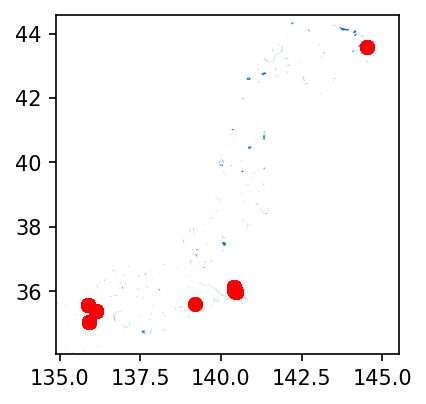

In [58]:
### checking missing geomerty locations

# lon = -87.054512
# lat = 42.559865

# ew_bb = (sites3.lon>lon-0.5)&(sites3.lon<lon+0.5)
# ns_bb = (sites3.lat>lat-0.5)&(sites3.lat<lat+0.5)


trysites = sites3[sites3.source=='GEMSTAT'].set_geometry('geometry_ll').reset_index()

## country outlines
# ct = gp.read_file('.//Country boundaries//CNTR_RG_60M_2016_4326.shp')
# ct = ct.to_crs(sites2.crs)

minx, miny, maxx, maxy = trysites.geometry.total_bounds

fig, ax = plt.subplots(dpi=150, figsize =(5, 3))

jwb.plot(ax=ax)
trysites[trysites.geometry_poly.isna()].plot(color='r',ax=ax,alpha=0.2)


ax.set_xlim(minx - 1, maxx + 1) 
ax.set_ylim(miny - 1, maxy + 1)

#### Check intersection across all relevant sites

In [86]:
### check number of sites without match
print(len(sites3[sites3.geometry_poly.isna()]))

### take copy of sites file and reset index
trysites = sites3[sites3.lon<-30].set_geometry('geometry_ll').reset_index() 

### set input polygon shapefile
trywb = uswb
trywb = trywb.to_crs(sites3.crs)

## create centroid coords to filter on
trywb['lon'] = trywb.geometry.centroid.x
trywb['lat'] = trywb.geometry.centroid.y

## set buffer distance - degrees to metres
buf_dis = 200/111139

## list for exceptions when copying geometry
geom_copy_excep = ['IDs not copied']

#sites3 = sites3.reset_index()

## loop through each site id and check intersection of lon lat against polygon in trysites

for sid in track(trysites[trysites.geometry_poly.isna()].sid.unique()):
    
    sp = trysites[trysites.sid==sid].buffer(buf_dis).geometry
    
    ## filter trywb on +-0.5 degree box
    lon = trysites[trysites.sid==sid].lon.unique()[0]
    lat = trysites[trysites.sid==sid].lat.unique()[0]
    
    ew_bb = (trywb.lon>lon-0.5)&(trywb.lon<lon+0.5)
    ns_bb = (trywb.lat>lat-0.5)&(trywb.lat<lat+0.5)
    
    testwb = trywb[ew_bb&ns_bb]
    
    intersects = testwb.geometry.map(lambda x: x.intersects(sp.geometry.any()))
    
    if len(intersects)>0 and sum(intersects[intersects==True])>0:
        
        try:
            sites3.loc[sites3.sid==sid,'geometry_poly'] = testwb[intersects].geometry.values[0]

        except:
            geom_copy_excep += sid
            print(f'geometry copy exception {sid}, geometry count: {len(testwb[intersects].geometry.values)}')
            

### check number of sites without match
print(len(sites3[sites3.geometry_poly.isna()]))

34186


 [████████████████████████████████████████████████████████████] 1680/1680 [08:60<00:00, 0.32s/it]

34186


In [89]:
pickle.dump(sites3,open('sites3.p','wb'))

### Create site polygon file

In [24]:
sites_poly = sites3[['sid','lon','lat','geometry_poly']].drop_duplicates().set_geometry('geometry_poly')

In [25]:
sites_poly.to_file('sites_poly.shp')
#pickle.dump(sites_poly,open('sites_poly.p','wb'))

### Manual checking with interactive plot

In [31]:
buf_dis = 100/111139
bufsites = trysites[(trysites.lon>20.371883)&(trysites.geometry_poly.isna())].buffer(buf_dis)
sitesbuf = gp.GeoDataFrame(geometry=bufsites.geometry,crs=sites2.crs)

site = gp.GeoDataFrame(geometry=sites2[sites2.index.get_level_values(0)=='LTL148'].geometry,crs=sites2.crs)

In [102]:
site = trysites.loc[trysites.source=='GEMSTAT',['sid','geometry_ll']].set_geometry('geometry_ll')

In [103]:
m = Map(center=(35, 139), zoom = 9, basemap= basemaps.Esri.WorldTopoMap)


ukwb_tp = GeoData(geo_dataframe = jwb,
                   style={'color': 'black', 'fillColor': '#1e7a65', 'opacity':0.5, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
                   hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
                   name = 'EA wb')

# sites_buff = GeoData(geo_dataframe = sitesbuf,
#                    style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0.5, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
#                    hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
#                    name = 'Sites')

sites = GeoData(geo_dataframe = site,
                   style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0.5, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
                   hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
                   name = 'EEA Lakes')

m.add_layer(ukwb_tp)
#m.add_layer(sites_buff)
m.add_layer(sites)
m.add_control(LayersControl())

m

Map(center=[35, 139], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_te…

<br>

***


## Open street map data retrivel

In [78]:
### Open shapefile for country borders for bbox
ct = gp.read_file('.//Country boundaries//CNTR_RG_60M_2016_4326.shp')
ct = ct.to_crs(sites2.crs)
#ct.total_bounds

### OSM call

In [51]:
# total_bounds returns minx, miny, maxx, maxy
# osm call takes min lon, min lat, max lon, max lat

outer = ct.total_bounds

### manual bbox definitions
outer[3] = 37.94 # ymax
outer[1] = 37.92 # ymin
outer[2] = 22.30 # xmax
outer[0] = 22.27 # xmin


polygon_geom = Polygon([(outer[0],outer[1]),(outer[0],outer[3]),(outer[2],outer[3]),(outer[2],outer[1])])

In [53]:
### List of map tags https://wiki.openstreetmap.org/wiki/Map_Features

osm_lakes = geopandas_osm.osm.query_osm('way', polygon_geom, recurse='down', tags=['natural=water']) #,'water=lake'

TypeError: sort_index() got an unexpected keyword argument 'by'

### Using pyrosm

In [9]:
## set pbf file path 
fp = "E:/University College London/O'Sullivan, Aidan - SDG6/Waterbody shapefiles/Japan/kanto-latest.osm.pbf"

# Initialize the OSM parser object
osm = OSM(fp)

## create filter
my_filter = {"natural": ["water"]}

## run get command
natural = osm.get_natural(custom_filter=my_filter)
natural.head()

,lon,tags,timestamp,version,lat,changeset,id,natural,water,geometry,osm_type,wetland
0,139.343460,None,1338906228,1,35.408985,0.0,1777121518,water,None,POINT (139.34346 35.40899),node,NaN
1,139.830994,"{""description"":""\u6C34\u98F2\u307F\u3070""}",1360025319,1,35.666843,0.0,2142096048,water,None,POINT (139.83099 35.66684),node,NaN
2,139.481033,None,1368243026,3,35.352013,0.0,2299065438,water,None,POINT (139.48103 35.35201),node,NaN
3,139.479584,"{""name"":""\u6C34\u8DEF\u8DE1"",""description"":""\u...",1468802023,3,35.348724,0.0,2299094117,water,None,POINT (139.47958 35.34872),node,NaN
4,139.596878,"{""name"":""\u6C34\u8FBA\u89B3\u5BDF\u5712"",""name...",1560798482,4,35.738041,0.0,2337808463,water,None,POINT (139.59688 35.73804),node,NaN


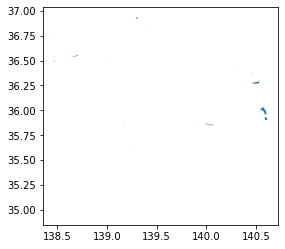

In [18]:
natural[(natural.geometry.type=='Polygon')&(natural.water=='lake')].plot()

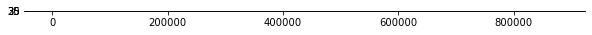

In [19]:
## plot data
natural[natural.geometry.type=='Polygon'].plot(legend=True, figsize=(10,6))

### Write to file

In [110]:
### Shape file
osm_lakes[osm_lakes.geometry.type=='LineString'].geometry.to_file('osm_lakes_gr.shp')

### CSV
osm_lakes.to_csv('osm_lakes_sk.csv')

### Interactive plot

In [111]:
m = Map(center=(52.3,8.0), zoom = 6, basemap= basemaps.Esri.WorldTopoMap)

pl_wb = wb[wb.country=='SK']
pl_osm = osm_lakes[osm_lakes.water=='lake']

osm = GeoData(geo_dataframe = pl_osm,
                   style={'color': 'black', 'fillColor': '#1e7a65', 'opacity':0.5, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
                   hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
                   name = 'OSM Lakes')

wb = GeoData(geo_dataframe = pl_wb,
                   style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0.5, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
                   hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
                   name = 'EEA Lakes')

m.add_layer(osm)
m.add_layer(wb)
m.add_control(LayersControl())

m

Map(center=[52.3, 8.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_…

### Globo Lakes dataset

In [3]:
from netCDF4 import Dataset
import numpy as np

In [4]:
gllakes = 'globolakes-static_water_bodies_IDs_Map-300m-P5Y-2005-ESACCI_WB-fv1.0.nc'
gllakes = Dataset(gllakes, mode='r')

In [5]:
list(gllakes.variables)

['lat', 'lat_bnds', 'lon', 'lon_bnds', 'WB_ID']

In [10]:
lons = gllakes.variables['lon'][:]
lats = gllakes.variables['lat'][:]
# lons = gllakes.variables['lon_bnds'][:]
# lats = gllakes.variables['lat_bnds'][:]
# wbid = gllakes.variables['WB_ID'][:]
gllakes.close()

In [54]:
%pwd

'C:\\Users\\User'

In [46]:
211*5000/3600/24

12.210648148148147